In [1]:
from __future__ import division

import os
import numpy as np
import time, timeit
import signal
import scipy.io as scio
from scipy import stats
from scipy.sparse import coo_matrix
from MDPD import *
from MDPD.readers import *
from MDPD import utils
import matplotlib.pyplot as plt
import matplotlib

----
## Read Data

In [2]:
# folder = '/media/vzhao/Data/crowdsourcing_datasets/'
folder = '/Users/vincent/Documents/Research/MDPD/crowdsourcing_datasets'

In [20]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'bird', 'bluebird_crowd.txt'), os.path.join(folder, 'bird', 'bluebird_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:], dtype=np.bool)
print train.shape

(108, 39, 2)


In [11]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'dog', 'dog_crowd.txt'), os.path.join(folder, 'dog', 'dog_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

2018-04-03 00:53:39,413 : INFO : Data has missing values. A new label is created to represent the missing values.


(807, 109, 5)


In [10]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'rte', 'rte_crowd.txt'), os.path.join(folder, 'rte', 'rte_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

2018-04-03 00:53:33,238 : INFO : Data has missing values. A new label is created to represent the missing values.


(800, 164, 3)


In [35]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'trec', 'trec_crowd.txt'), os.path.join(folder, 'trec', 'trec_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

2018-04-03 00:56:06,476 : INFO : Data has missing values. A new label is created to represent the missing values.


(2275, 762, 3)


In [26]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'web', 'web_crowd.txt'), os.path.join(folder, 'web', 'web_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

2018-04-03 00:54:46,679 : INFO : Data has missing values. A new label is created to represent the missing values.


(2653, 177, 6)


---
## Analysis

### Original Mutual Information Residue

In [36]:
%%time
# Original mutual information residue (G score)
score_origin = utils.Feature_Selection.MI_score(train, rm_diag=True, lock=lock)
dim = train.shape[1]
print np.sum(score_origin) / (dim * (dim-1))

7.67306250285e-05
CPU times: user 1.65 s, sys: 221 ms, total: 1.87 s
Wall time: 993 ms


### Mutual Information Residue if use the true label as the posterior distribution

In [37]:
# label to log_post
def label2logpost(label, ncomp):
    nsample = label.shape[0]
    post = np.zeros((nsample, ncomp))
    for i in xrange(nsample):
        post[i, label[i]] = 1
    return np.log(post)
log_post = label2logpost(label,label.max()+1)
utils.log_replace_neginf(log_post)

/Users/vincent/.virtualenvs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [38]:
%%time
score, weighted = MDPD.utils.Feature_Selection.MI_score_conditional(train, log_post, rm_diag=True, lock=lock)
sigmas = score.sum(axis=1) * weighted[np.newaxis, :]
print 'Mutual Information Residue if use the true label as the posterior distribution'
print np.sum(sigmas) / (dim * (dim - 1))

Mutual Information Residue if use the true label as the posterior distribution
8.19015877294e-05
CPU times: user 6.8 s, sys: 526 ms, total: 7.33 s
Wall time: 3.92 s


#### Reference G Statistics

In [39]:
percentages = [99,95,90,75,50]
percentiles = [stats.chi2.ppf(x/100.,3) / (2 * train.shape[0]) for x in percentages]

print 'Reference G statistis at {} percentile'.format(percentages)
print percentiles

Reference G statistis at [99, 95, 90, 75, 50] percentile
[0.0024933773033284333, 0.0017175226160991597, 0.0013739315672901809, 0.00090293295288622333, 0.000519994260302272]


### Plot Mutual Information Residue if use the true label as the posterior distribution

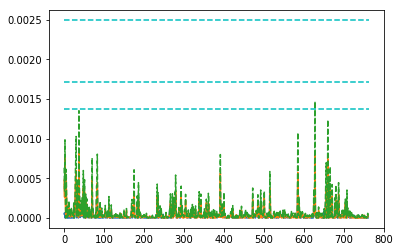

In [40]:
plt.figure()
for k in xrange(train.shape[2]-1 if np.any(lock) else train.shape[2]):
    plt.plot(sigmas[:,k]/(dim-1))
plt.plot(score_origin.sum(axis=1)/(dim-1), '--')
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

### Mixture Model with Feature Selection Performance

#### Feature Ranking

In [ ]:
%%time
features, score = utils.Feature_Selection.MI_feature_ranking(train)
plt.plot(score/(train.shape[1]-1))
# plot reference G statistics
for foo in percentiles:
    plt.plot([0, len(score)], [foo, foo], 'c--')
features

#### Accuracy and Mutual Information Residue

In [ ]:
Ntop = 9

In [ ]:
# Feature Selection
model = MDPD.MDPD()
model.fit(train, ncomp=5, init='majority', verbose=False, features=features[:Ntop], niter=50, lock=lock)
model.accuracy(train, label)
model.MI_residue(train)

In [ ]:
# optional
model.change_features(train, features=range(model.dim))
model.accuracy(train, label)

### Vanilla Model Performance
#### Accuracy

In [ ]:
# basic model with majority vote initialization
model_basic = MDPD.MDPD()
model_basic.fit(train, ncomp=4, init='majority', verbose=False, niter=50, lock=lock)
model_basic.accuracy(train, label)

#### Mutual Information Residue

In [ ]:
model_basic.MI_residue(train, lock)
# MI residue conditional on the features (although basic model is using all features to learn the model)
features, score = utils.Feature_Selection.MI_feature_ranking(train)
features = np.array(features)
log_post = model_basic.log_posterior(train)
score, weights = utils.Feature_Selection.MI_score_conditional(train,log_post,rm_diag=True, lock=lock)
score_selected = score[features[:Ntop, np.newaxis], features[:Ntop]]
print 'MI residue conditional on the features (although basic model is using all features to learn the model)'
print np.sum(score_selected.sum(axis=(0,1)) * weights) / (Ntop * (Ntop - 1))

### 

In [ ]:
matplotlib.matplotlib_fname()